# DM-37628: timing of new implementation of generateDonutDirectDetect


I bring here parts of exploring alternative source detection ways on a simulated `LsstCam` exposure image, porting them from `generateDonutDirectDetect` 



In [2]:
from lsst.ts.wep.utility import (
    DefocalType,
    DonutTemplateType,
    getCamTypeFromButlerName,
    createInstDictFromConfig,
    runProgram,
    writePipetaskCmd, 
    writeCleanUpRepoCmd,
    getModulePath,
    CentroidFindType
)


In [3]:
import os
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams
from astropy.visualization import ZScaleInterval
from scipy.spatial.distance import cdist
from copy import copy
from lsst.daf import butler as dafButler

In [4]:

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
centerRaft = ["R22_S10", "R22_S11"]
print(testDataDir)
butler = dafButler.Butler(repoDir)
registry = butler.registry


/sdf/group/rubin/ncsa-home/home/scichris/aos/ts_wep/tests/testData


run ISR on the simulated LsstCam data:

In [6]:
# Run pipeline command
runName = "run1"
instrument = "lsst.obs.lsst.LsstCam"
collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
exposureId = 4021123106001  # Exposure ID for test extra-focal image
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")

In [7]:
os.listdir(testPipelineConfigDir)

['testDonutCatWcsPipeline.yaml',
 'testCutoutsLatissPipeline.yaml',
 'testCalcZernikesLatissPipeline.yaml',
 'testBasePipeline.yaml',
 'testDonutFromRefitWcsPipeline.yaml',
 'testOnlyISR_lsst.yaml',
 'testCalcZernikesCwfsPipeline.yaml',
 'testCutoutsCwfsPipeline.yaml',
 'testCutoutsFamPipeline.yaml',
 'testCalcZernikesScienceSensorPipeline.yaml',
 'testDonutDirectDetectPipeline.yaml',
 'testIsrPipeline.yaml']

In [8]:
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testOnlyISR_lsst.yaml"
)
pipetaskCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
# Update task configuration to match pointing information
pipetaskCmd += f" -d 'exposure IN ({exposureId})'"

#Check that run doesn't already exist due to previous improper cleanup
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

# Run pipeline task
runProgram(pipetaskCmd)

lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 1 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 2 quanta, 10 dataset nodes, and 8 edges from 2 query row(s).
lsst.pipe.base.quantum_graph_builder INFO: Generated 2 quanta for task isr.
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 2 quanta for 1 task, graph ID: '1695070462.7516758-2862058'
Quanta Tasks
------ -----
     2   isr
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instrument: 'LSSTCam', detector: 94, exposure: 4021123106001, ...}.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Constructing task and executing quantum for label=isr dataId={instrument: 'LSSTCam', detector: 94, exposure: 4021123106001, ...}.
lsst.isr INFO: Converting exposure to floating point values.
lsst.isr INFO: Assembling CCD fro

Inspect the results:

In [9]:
exposureId = 4021123106001
runName = "run1"
butler = dafButler.Butler(repoDir)
dataIdExtra = {"instrument": "LSSTCam", "detector": 94, "exposure": exposureId}
exposureExtra = butler.get(
    "postISRCCD", dataId=dataIdExtra, collections=[runName]
)

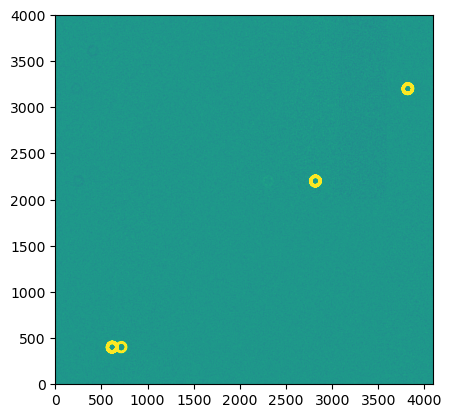

In [10]:
%matplotlib inline
zscale = ZScaleInterval()
data = exposureExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

Now, run the updated version of `generateDonutDirectDetect` on this image. We know that previously the adaptative thresholding took 2 mins per image. 

In [12]:
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTask,
    GenerateDonutDirectDetectTaskConfig,
)
config = GenerateDonutDirectDetectTaskConfig()


I align the configs with those of https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testDonutDirectDetectPipeline.yaml :

    GenerateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          instObscuration: 0.61
          instFocalLength: 10.312
          instApertureDiameter: 8.36
          instDefocalOffset: 1.5
          instPixelSize: 10.0e-6

In [14]:
config.instObscuration

0.61

In [15]:
config.instFocalLength

10.312

In [16]:
config.instApertureDiameter

8.36

In [21]:
config.instDefocalOffset = 1.5

In [22]:
config.instDefocalOffset

1.5

In [19]:
config.instPixelSize

1e-05

All the defaults were correct for LsstCam, except for the `instDefocalOffset` which wasn't set at all. 

In [24]:
task = GenerateDonutDirectDetectTask(config=config)

In [26]:
camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections=["LSSTCam/calib/unbounded",],
)

In [35]:
%%timeit
donutCatalog = task.run(exposureExtra,camera )

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 3 of 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 3/3 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 3 of 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 3/3 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 3 of 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 3/3 references
INFO:lsst.generateDonutDirectDetectTask.measureme

1.43 s ± 58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
donutDf = donutCatalog.donutCatalog

In [36]:
donutDf

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,6.281630,-0.001379,625.144860,397.892756,R22_S11,3.497431e+06,[],[]
1,0.000189,0.000743,2814.112738,2195.935518,R22_S11,3.405078e+06,[],[]
2,0.001157,0.001712,3812.908192,3194.965238,R22_S11,3.369313e+06,[],[]


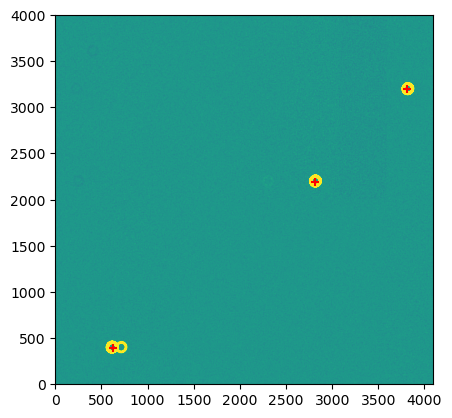

In [34]:
data = exposureExtra.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

plt.scatter(donutDf['centroid_x'], donutDf['centroid_y'], marker='+',
           s=40, c='red')

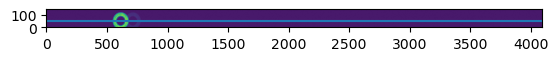

In [51]:
plt.imshow(data[350:500,:], origin='lower')
plt.axhline(50)

This quick example shows that the average of 2min 2 sec per loop has been reduced to 1.43 sec per loop, i.e. over 100 times faster.  The only drawback is that the blended donut here is not recognized as a blend. If we use custom magnitude settings in donutSelector to preclude the possibility that the faint donut is detected but not selected:

In [37]:
config = GenerateDonutDirectDetectTaskConfig()
config.instDefocalOffset = 1.5
config.donutSelector.useCustomMagLimit =  True
config.donutSelector.magMin = 0 
config.donutSelector.magMax = 20 

In [38]:
task = GenerateDonutDirectDetectTask(config=config)
donutCatalog = task.run(exposureExtra, camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 3 of 3 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 3/3 references


In [39]:
donutCatalog.donutCatalog


,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,6.281630,-0.001379,625.144860,397.892756,R22_S11,3.497431e+06,[],[]
1,0.000188,0.000743,2814.080172,2195.882582,R22_S11,3.403821e+06,[],[]
2,0.001157,0.001712,3812.908192,3194.965238,R22_S11,3.369313e+06,[],[]


No - still only the brightest sources get detected. What's the flux difference between the two faint sources? 

Text(0, 0.5, 'counts')

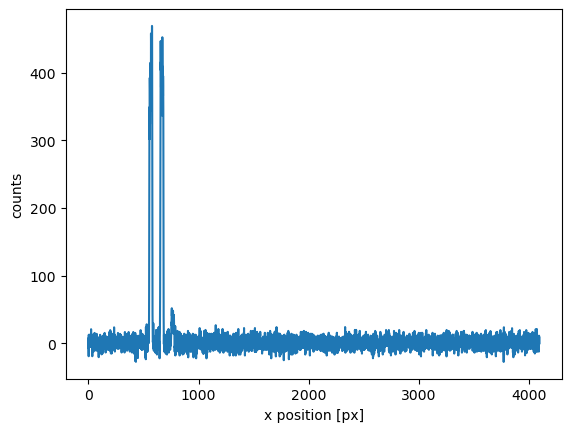

In [54]:
data = exposureExtra.image.array
plt.plot(data[400,:])
plt.xlabel('x position [px]')
plt.ylabel('counts')

So the main donut is ~450 counts, whereas the faint blended donut is ~60 counts, in the absence of background. In reality the fainter donut would be likely too faint to be detected above the background threshold. 

## Run on `auxTel` data

In [57]:
butler = dafButler.Butler(
    '/sdf/data/rubin/repo/embargo/',
    collections=['LATISS/runs/quickLook'],
    instrument='LATISS'
)
day = 20230815
seqNum = 68
dataId = {'day_obs': day,'detector':0, 'seq_num':seqNum}
exposure = butler.get('quickLookExp', dataId=dataId, )

In [62]:
camera = butler.get(
    "camera",
    dataId={"instrument": "LATISS"},
    collections=['LATISS/runs/quickLook'],
)

In [64]:
camera.getName()

'LATISS'

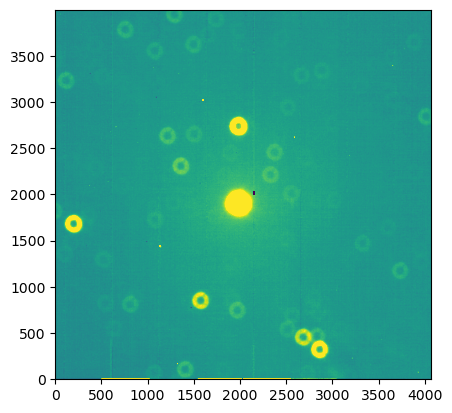

In [58]:
zscale = ZScaleInterval()
data = exposure.image.array 
vmin,vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, 
           origin='lower')

Run `generateDonutDirectDetect` on this postISR image. How long does it take? 

We take the config from https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testCalcZernikesLatissPipeline.yaml : 


    generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          # Obscuration (inner_radius / outer_radius of primary mirror)
          instObscuration: 0.3525
          # Focal length in m
          instFocalLength: 21.6
          # Aperture diameter in m
          instApertureDiameter: 1.2
          # Move the M2 to fake the move of focal plane dz
          # Move the M2 by 0.8 mm = move the focal plane by 32.8 mm  (magnification of 41)
          # Defocal distance offset in mm
          instDefocalOffset: 32.8
          # Camera pixel size in m
          instPixelSize: 10.0e-6
          # Set the optical model for LATISS
          opticalModel: 'onAxis'
          # Set configuration for donutSelector. The customMagLimit
          # must be used because otherwise magnitude limits
          # are checked in policy/task/magLimitStar.yaml file,
          # and auxTel filter names tend to fluctuate (currently 'white',
          # but several other have been observed due to rapid development)
          donutSelector.useCustomMagLimit: True
          donutSelector.magMin: 4.
          donutSelector.magMax: 15.
          donutSelector.sourceLimit: 1



In [94]:
# setup for AuxTel
config = GenerateDonutDirectDetectTaskConfig()
config.instObscuration = 0.3525
config.instFocalLength = 21.6
config.instApertureDiameter = 1.2
config.instDefocalOffset = 32.8
config.instPixelSize = 10.0e-6
config.opticalModel = 'onAxis'
#config.doDonutSelection =  False
config.donutSelector.useCustomMagLimit =  True
config.donutSelector.magMin = 1.
config.donutSelector.magMax =  25.

# want to see all sources...
# config.donutSelector.sourceLimit: 1

In [95]:
taskLatiss = GenerateDonutDirectDetectTask(config=config)

In [97]:
%%timeit
donutCatalog = taskLatiss.run(exposure, camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 9 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 9 of 9 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 4/9 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 9 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 9 of 9 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


1.31 s ± 67.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
donutDf = donutCatalog.donutCatalog

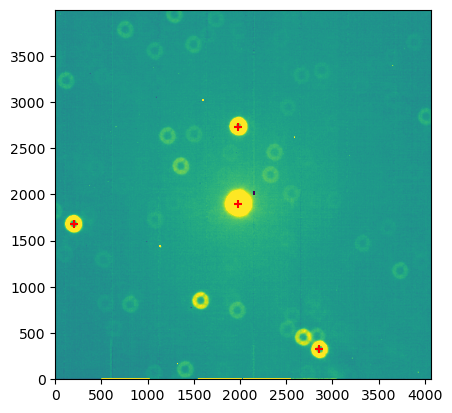

In [83]:
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, origin='lower')

plt.scatter(donutDf['centroid_x'], donutDf['centroid_y'], marker='+',
           s=40, c='red')

So we see that for real auxTel images it is also about 1.3 sec per image, i.e. 100 times faster than the previous implementation.